Материалы по теме: 

[The Unreasonable Effectiveness of Recurrent Neural Networks, Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[Understanding LSTM Networks, Christopher Olah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)


Сегодняшний семинар на основе: 

[материала](https://github.com/artemovae/NLP-seminar-LM) из курса Кати Артемовой 

[материала от closeheat](https://github.com/closeheat/pytorch-lstm-text-generation-tutorial)  по генерации шуток с помощью LSTM


*Языковая модель* - оценивает вероятности встретить последовательность слов $w_1, \ldots, w_n$:   
$$\mathbf{P}(w_1, \ldots, w_n) = \prod_k \mathbf{P}(w_k|w_{k-1}, \ldots, w_{1}).$$


*мой дядя самых честных __*


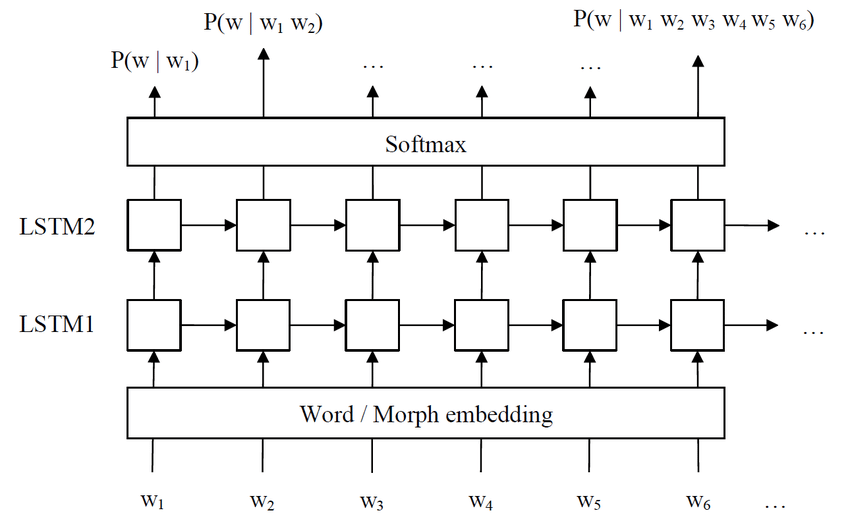

From: [Tarján et al 2019](https://www.researchgate.net/publication/336086782_Investigation_on_N-Gram_Approximated_RNNLMs_for_Recognition_of_Morphologically_Rich_Speech)

### Импорты

In [ ]:
import argparse
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import Counter

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)

### Данные

In [ ]:
!wget https://raw.githubusercontent.com/artemovae/NLP-seminar-LM/master/dinos.txt

In [ ]:
! head dinos.txt

In [ ]:
class DinosDataset(Dataset):
    def __init__(self):
        super().__init__()
        with open('dinos.txt') as f:
            content = f.read().lower()
            self.vocab = sorted(set(content)) + ['<', '>']
            self.vocab_size = len(self.vocab)
            self.lines = content.splitlines()
        self.word2id = {c:i for i, c in enumerate(self.vocab)}
        self.id2word = {i:c for i, c in enumerate(self.vocab)}
    
    def __getitem__(self, index):
        line = self.lines[index]
        x_str = '<' + line 
        y_str = line + '>' 
        x = torch.empty(len(x_str), dtype=torch.long, device=device)
        y = torch.empty(len(x_str), dtype=torch.long, device=device)
        for i, (x_ch, y_ch) in enumerate(zip(x_str, y_str)):
            x[i] = self.word2id[x_ch]
            y[i] = self.word2id[y_ch]
        
        return x, y
    
    def __len__(self):
        return len(self.lines)

In [ ]:
dinodataset = DinosDataset()
dinodataloader = DataLoader(dinodataset, shuffle=True)

In [ ]:
x, y = next(iter(dinodataloader))

In [ ]:
x

In [ ]:
y

In [ ]:
[dinodataset.id2word[int(i)] for i in y[0]]

### Модель

In [ ]:
class LModel(nn.Module):
    def __init__(self, vocab_size):
        super(LModel, self).__init__()
        self.lstm_size = 10
        self.embedding_dim = 5
        self.num_layers = 1

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers
        )
        self.i2o = nn.Linear(self.lstm_size, vocab_size)

    def forward(self, x, prev_state=None):
        embed = self.embedding(x)
        if prev_state:
          output, state = self.lstm(embed, prev_state)
        else:
          output, state = self.lstm(embed)
        logits = self.i2o(output)

        return logits, state



In [ ]:
lm = LModel(len(dinodataset.id2word)).to(device)

In [ ]:
x

In [ ]:
emb_l = nn.Embedding(29,5).to(device)
lstm_l = nn.LSTM(5, 10, num_layers=2).to(device)

In [ ]:
x

In [ ]:
y_pred, (state_h, state_c) = lstm_l(emb_l(x))

In [ ]:
print(y_pred.shape)
print(state_h.shape)
print(state_c.shape)

In [ ]:
state_h[-1]

In [ ]:
y_pred

In [ ]:
x, y  = next(iter(dinodataloader))

In [ ]:
y_pred, (state_h, state_c) = lm(x)

In [ ]:
y_pred.shape

In [ ]:
def sample(dataset, model):
    model.eval()
    newline_id = dataset.word2id['>']
    word_size = 0
    with torch.no_grad():
        state_h = None
        start_id = dinodataset.word2id['<']
        indices = [start_id]
        word_size += 1
        pred_id = start_id
        x = torch.tensor([[pred_id]]).to(device)
        
        while pred_id != newline_id and word_size != 20:
            if type(state_h) == torch.Tensor:
              logits, (state_h, state_c) = model(x, (state_h, state_c))
            else:
              logits, (state_h, state_c) = model(x)
            
            y_softmax_scores = torch.softmax(logits, dim=2)            
            pred_id = np.random.choice(np.arange(len(dinodataset.word2id)), p=y_softmax_scores.detach().cpu().numpy().ravel())
            indices.append(pred_id)
            x = torch.tensor([[pred_id]]).to(device)           
            word_size += 1
        
            if word_size == 20 and indices[-1] != newline_id:
                indices.append(newline_id)
    model.train()
    return ''.join([dinodataset.id2word[i] for i in indices])

#### как семплировать по вероятностям.  np.random.choice

In [ ]:
logits = y_pred[:, -1, :].unsqueeze(1)
print(logits.shape)
logits

In [ ]:
y_softmax_scores = torch.softmax(logits, dim=2)
y_softmax_scores.shape
y_softmax_scores

In [ ]:
#p = torch.nn.functional.one_hot(torch.tensor(3),29)
p = y_softmax_scores.detach().cpu().numpy().ravel()

In [ ]:
p

In [ ]:
np.arange(len(dinodataset.word2id))

In [ ]:
pred_id = np.random.choice(np.arange(len(dinodataset.word2id)), p=p)
print(pred_id)

#### сделаем предсказание нашей необученной сетью

In [ ]:
sample(dinodataset, lm)

In [ ]:
def train(dataset, dataloader, model, max_epochs=20):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(),  lr=1.)

    for epoch in range(max_epochs):  
        print('\n')
        print('epoch', epoch)
        epoch_loss = 0
        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            y_pred, (state_h, state_c) = model(x)
            loss = criterion(y_pred.transpose(1, 2), y)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            if (batch+1) % 100 == 0:  
                print(sample(dataset, model))

        print('loss', epoch_loss/(batch + 1))

        


In [ ]:
lm = LModel(len(dinodataset.id2word)).to(device)
train(dinodataset, dinodataloader, lm)